In [ ]:
!pip install -q "monai-weekly[pillow, tqdm]"

In [ ]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import numpy as np
import tensorflow as tf

from sklearn.metrics import classification_report

import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.4.dev2421
Numpy version: 1.25.2
Pytorch version: 2.3.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 1070036ea3c30176fc82cfb15952387bed8b8a90
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 9.4.0
Tensorboard version: 2.15.2
gdown version: 4.7.3
TorchVision version: 0.18.0+cu121
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.41.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visi

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpj6jqyklf


In [ ]:
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)


set_determinism(seed=0)

MedNIST.tar.gz: 59.0MB [00:01, 52.1MB/s]                            

2024-05-30 22:12:39,895 - INFO - Downloaded: /tmp/tmpj6jqyklf/MedNIST.tar.gz


2024-05-30 22:12:40,084 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-05-30 22:12:40,086 - INFO - Writing into directory: /tmp/tmpj6jqyklf.


In [ ]:
class_names = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [os.path.join(data_dir, class_names[i], x) for x in os.listdir(os.path.join(data_dir, class_names[i]))]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


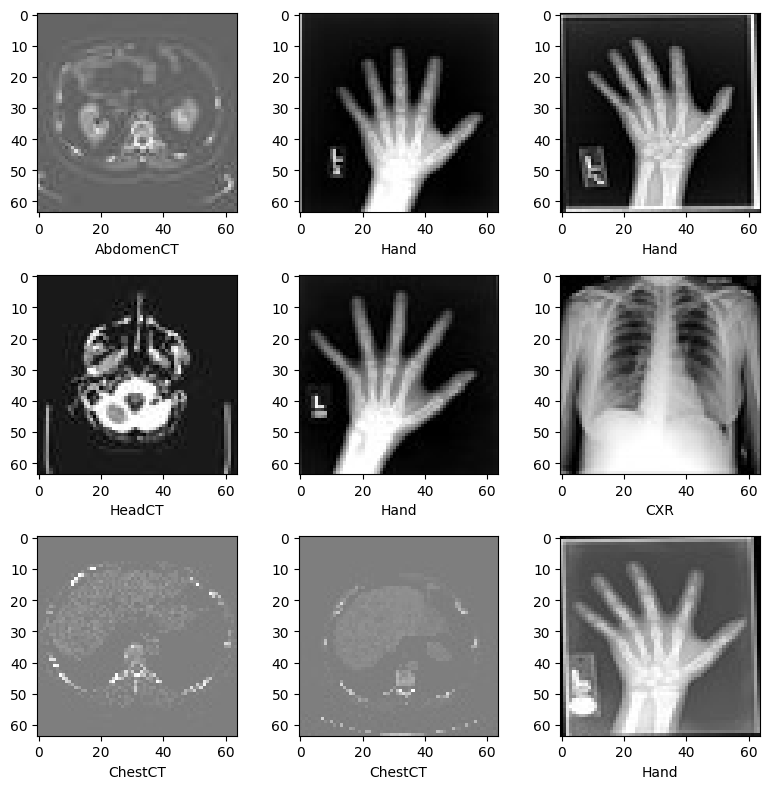

In [ ]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

Prepare Training, Validation, and Test Data Lists (10% validation/10% test)

In [ ]:
from sklearn.model_selection import train_test_split

# Convert lists to numpy arrays
image_files_list = np.array(image_files_list)
image_class = np.array(image_class)

# 30% Testing
test_frac = 0.3

# Split the data into training+validation and test sets
train_x, test_x, train_y, test_y = train_test_split(image_files_list, image_class, test_size=test_frac, random_state=42)

print(f"Training count: {len(train_x)}, Test count: {len(test_x)}")

Training count: 41267, Test count: 17687


Define Preprocessing function to read in each image from the file names (train_x is just the file names, not the image pixel data)

In [ ]:
# Define a function to preprocess the image files
def preprocess_image(file_path):
    return PIL.Image.open(file_path)

'''
Preprocessing for Training Set
'''

# Preprocess train_x
train_x_processed = []
for file_path in train_x:
    processed_image = preprocess_image(file_path)
    train_x_processed.append(processed_image)
train_x_processed = tf.stack(train_x_processed)
print(train_x_processed)

tf.Tensor(
[[[ 38  37  35 ...  25  26  26]
  [ 37  35  33 ...  25  26  26]
  [ 34  33  31 ...  23  24  25]
  ...
  [ 19  18  16 ...   6   7   8]
  [ 18  17  16 ...   7   8   9]
  [ 18  17  16 ...   8   9  10]]

 [[ 25  25  25 ...  25  25  25]
  [ 25  25  25 ...  25  25  25]
  [ 25  25  25 ...  25  25  25]
  ...
  [ 25  25  25 ...  25  25  25]
  [ 25  25  25 ...  25  25  25]
  [ 25  25  25 ...  25  25  25]]

 [[ 25  25  25 ...  25  25  25]
  [ 25  25  25 ...  25  25  25]
  [ 25  25  25 ...  25  25  25]
  ...
  [ 25  25  25 ...  25  25  25]
  [ 25  25  25 ...  25  25  25]
  [ 25  25  25 ...  25  25  25]]

 ...

 [[101 101 101 ... 101 101 101]
  [101 101 101 ... 101 101 101]
  [101 101 101 ... 101 101 101]
  ...
  [104 102  91 ... 135 116  96]
  [ 94 101 112 ...  89  92 103]
  [102  96  98 ... 104 103 101]]

 [[  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ..

Define Model & Train

In [ ]:
# Model definition
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((64, 64, 1), input_shape=(64, 64)),  # Reshape to add channel dimension
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')  # Adjust output units as per your data
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_x_processed, train_y, epochs=10, validation_split=0.1)

Epoch 1/10
1161/1161 [==============================] - 9s 7ms/step - loss: 0.2171 - accuracy: 0.9695 - val_loss: 0.0320 - val_accuracy: 0.9915
Epoch 2/10
1161/1161 [==============================] - 8s 7ms/step - loss: 0.0205 - accuracy: 0.9936 - val_loss: 0.0258 - val_accuracy: 0.9937
Epoch 3/10
1161/1161 [==============================] - 8s 7ms/step - loss: 0.0363 - accuracy: 0.9913 - val_loss: 0.0368 - val_accuracy: 0.9925
Epoch 4/10
1161/1161 [==============================] - 13s 11ms/step - loss: 0.0591 - accuracy: 0.9872 - val_loss: 0.0142 - val_accuracy: 0.9949
Epoch 5/10
1161/1161 [==============================] - 11s 9ms/step - loss: 0.0100 - accuracy: 0.9964 - val_loss: 0.0245 - val_accuracy: 0.9954
Epoch 6/10
1161/1161 [==============================] - 8s 7ms/step - loss: 0.0062 - accuracy: 0.9980 - val_loss: 0.0566 - val_accuracy: 0.9838
Epoch 7/10
1161/1161 [==============================] - 7s 6ms/step - loss: 0.0244 - accuracy: 0.9947 - val_loss: 0.0142 - val_accura

Plot the Loss and Metric

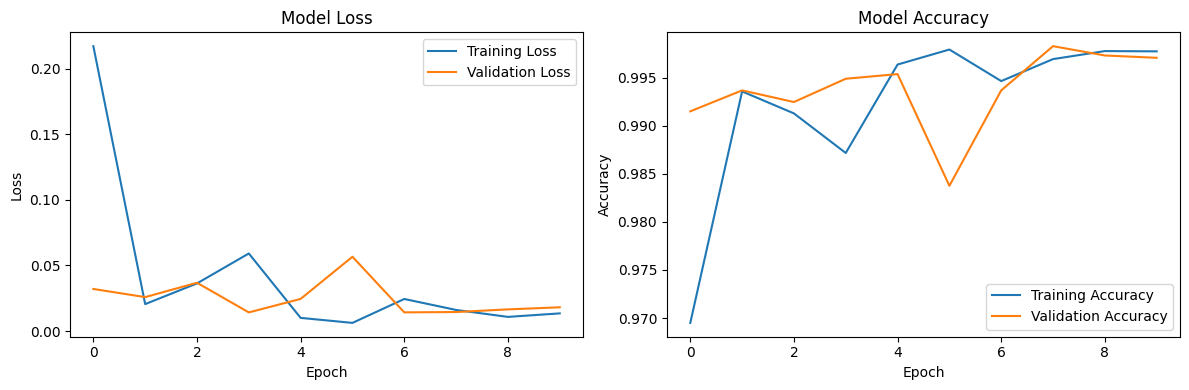

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Plot training history (loss and accuracy)
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)


Evaluate on Testing Dataset

In [ ]:
'''
Preprocessing for Testing Set
'''
test_x_processed = []
for file_path in test_x:
    processed_image = preprocess_image(file_path)
    test_x_processed.append(processed_image)
test_x_processed = tf.stack(test_x_processed)
print(test_x_processed)

tf.Tensor(
[[[101 101 101 ... 101 101 101]
  [101 101 101 ... 101 101 101]
  [101 101 101 ... 101 101 101]
  ...
  [104 104 104 ...  94  96 107]
  [ 97  98  99 ...  97  98 102]
  [102 103 103 ... 106 107 100]]

 [[101 101 101 ... 101 101 101]
  [101 101 101 ... 101 101 101]
  [101 101 101 ... 101 101 101]
  ...
  [ 96  97 101 ... 107 109  90]
  [113 100  91 ... 107 104 102]
  [102 101 103 ... 100  97 102]]

 [[ 14  15  15 ...   4   4   4]
  [ 14  14  15 ...   3   4   4]
  [ 14  14  15 ...   2   3   3]
  ...
  [ 27  26  25 ...   9  10  10]
  [ 29  28  27 ...  12  12  12]
  [ 32  31  30 ...  13  13  13]]

 ...

 [[ 87  13   0 ...   8   0   0]
  [ 27   0   3 ...   0   3   3]
  [ 27   0   5 ...  23   0   2]
  ...
  [  9   0   4 ... 146 118  94]
  [  5   0  24 ... 160 138 111]
  [ 11  14  71 ... 198 182 153]]

 [[ 25  25  25 ...  25  25  25]
  [ 25  25  25 ...  25  25  25]
  [ 25  25  25 ...  25  25  25]
  ...
  [ 26  21  27 ...  25  25  25]
  [ 25  22  27 ...  25  25  25]
  [ 24  22  27 ..

In [ ]:
'''
Generate predictions for the test dataset
'''
test_predictions = model.predict(test_x_processed)
test_predictions = tf.argmax(test_predictions, axis=1)

'''
Generate classification report for the test dataset
'''
class_names = ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
print(classification_report(test_y, test_predictions, target_names=class_names, digits=4))

553/553 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

   AbdomenCT     0.9987    1.0000    0.9994      3077
   BreastMRI     0.9981    1.0000    0.9991      2648
         CXR     0.9983    0.9956    0.9969      2943
     ChestCT     0.9993    1.0000    0.9997      3016
        Hand     0.9953    0.9966    0.9960      2978
      HeadCT     0.9997    0.9974    0.9985      3025

    accuracy                         0.9982     17687
   macro avg     0.9982    0.9983    0.9982     17687
weighted avg     0.9982    0.9982    0.9982     17687

